<DIV ALIGN=CENTER>

# Introduction to Clustering
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore the concept of clustering, where
one tries to find groups or clusters of data points. Clustering is
generally an unsupervised learning technique, since we are simply using
the data features to determine some concept of _closeness_. One common
technique to determine clustering is too look for clusters of points by
using a metric, or distance measure. For example, one can use the
_Euclidean_ metric when data all have the same units (such as distance)
and dimensions. Other distance measures can be used in other cases to
determine closeness or similarity, such as _cosine_ similarity.
Selection of an appropriate metric, especially for high dimensional data,
is an important topic since we want to avoid the [_curse of
dimensionality_][cod].

For some algorithms, an initial estimate for the number of clusters is
required, for example $k$ in _k-means clustering_.  Other algorithms
compute the local density and assign points to clusters based on this
computed density, such as DBSCAN. In this Notebook, we demonstrate both
of these algorithms. First we use the Iris data set to find three
clusters by using he k-means algorithm. Afterwards, we introduce the
DBSCAN algorithm to compare its predictions. Finally, we use both of
these algorithms on the larger handwritten digit data set.

-----
[cod]: https://en.wikipedia.org/wiki/Curse_of_dimensionality
[edm]: https://en.wikipedia.org/wiki/Euclidean_distance
[cdm]: https://en.wikipedia.org/wiki/Cosine_similarity
[km]: https://en.wikipedia.org/wiki/K-means_clustering
[db]: https://en.wikipedia.org/wiki/DBSCAN

In [2]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-----

## Iris Data

We will use the standard Iris data set to explore how to use these basic
clustering algorithms, in this Notebook we will use k-means and DBSCAN.
The four primary dimensions of the data include Sepal Length, Sepal
Width, Petal Length, and Petal Width, which can be seen from the
following Iris picture (or type _virginica_).

![Iris picture from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg)

The data set consists of 150 total measurements of three different types
of Iris flowers, equally divided between three classes: Iris Setosa,
Iris versicolor, and Iris virginica. Before proceeding, we can examine
these data in the two principal components (as shown in the
[Introduction to Dimension Reduction][idr] Notebook.

-----

[idr]: intro2dr.ipynb

In [3]:
# We import helper code for getting and plotting the Iris data
from helper_code import iris as hi

# Now we grab the raw data, and also create a sampled grid of data.

# This code restricts the features to the top two PCA components
# This simplifies the viewing of the predited labels.

data = hi.get_data()
mdata = hi.get_mdata(data)

# Get features (x) and labels (y)
x = data[:, 0:2]
y = data[:, 2]

-----

## [Clustering][cl]

The next machine learning technique we will explore is cluster finding.
Clustering seeks to first find $N$ clusters in a data set and to
subsequently identify which data points belong to each cluster. While
there are a number of different approaches to clustering, one of the
easiest to understand is the k-means algorithm. In this algorithm we
start with a guess for the number of clusters (again this can be based
on a priori information or iteratively quantified). We randomly place
cluster centers in the data and determine how well the data _cluster_ to
these cluster centers. This information is used to pick new cluster
centers, via a weighting process, and the process continues until a
solution converges (or we reach a predefined number of iterations). This
process is displayed in the following figure from Wikipedia.

![KMeans Wikipedia Image][kmi]

We can employ k-means clustering with scikit-learn by using the `KMeans`
object within the `cluster` module. This algorithm requires an initial
estimate of the number of clusters to find as an input parameter. After
the model is created, we fit the model to the data and subsequently
obtain our model predictions. Note, this process is unsupervised in that
we do not use the label array in this process. After we find our
clusters, we plot the original data and the new clustered data in our
principal component axes to visually quantify how well the algorithm
performed.

-----
[cl]: https://en.wikipedia.org/wiki/Cluster_analysis
[km]: https://en.wikipedia.org/wiki/K-means_clustering
[kmi]: ../../Week1/notebooks/images/kmeans-wikipedia.png

In [4]:
# We will use kmeans form scikit-learn
from sklearn.cluster import KMeans

# We build our model assuming three clusters
k_means = KMeans(n_clusters=3, n_init=10)

# We fit our data to assign classes
k_means.fit(x)

# Obtain the predictions
y_pred = k_means.predict(x)

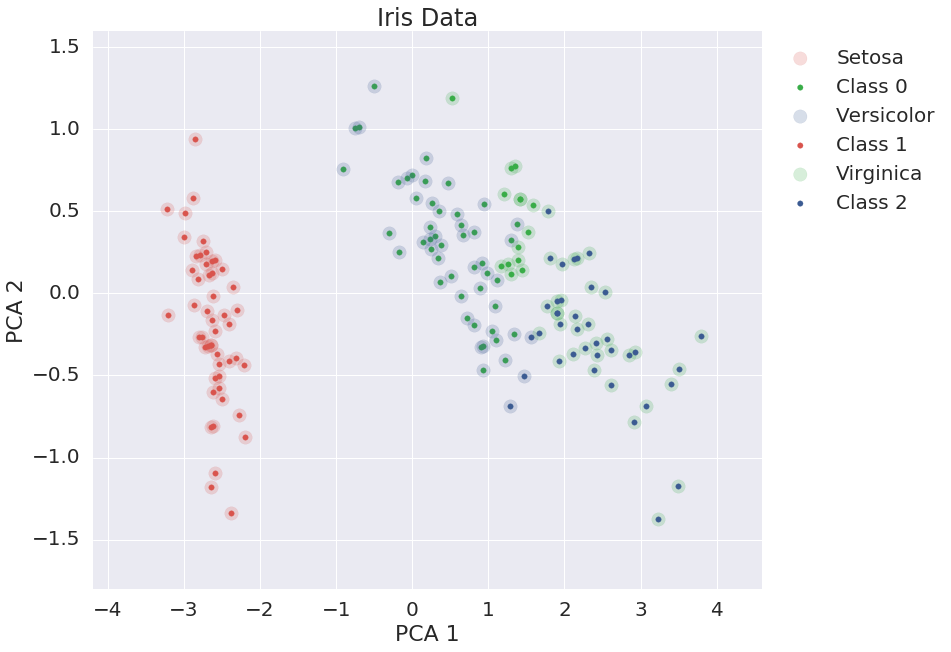

In [5]:
# Now we compare the cluster assignments to the real classes.

# Two sets of colors, can modify these to ensure colors match between known and predicted clusters.
clr = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["medium green"]]
pclr = [sns.xkcd_rgb["medium green"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]]

# Label data
lbls = ['Setosa', 'Versicolor', 'Virginica']
plbls = ['Class 0', 'Class 1', 'Class 2']
cols = ['PCA1', 'PCA2', 'Species']

# Data
dt = pd.DataFrame(data, columns = cols)

# Predicted Clusters
pc = pd.DataFrame(np.concatenate((x, y_pred.reshape((150, 1))), axis=1), columns = cols)

# Now make the plot (Reuse code from helper functions)
sns.set(font_scale=2.0)
fig, ax = plt.subplots(figsize=(12, 10))

for idx in range(3):
    
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], color=clr[idx], label=lbls[idx], alpha=0.2, s=180)

    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], color=pclr[idx], label=plbls[idx], alpha=1, s=30)

ax.set_xlim(-4.2, 4.6)
ax.set_ylim(-1.8, 1.6)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2)

sns.despine(offset=5, trim=True)
sns.set(font_scale=1.0)

-----

## [DBSCAN][db]

The previous algorithm, k-means, worked well for the Iris data set,
especially since we *new* there were three classes. While there are
automated methods for determining $k$ algorithmically, this requirement
is still an impediment for some applications. An alternative,
density-based clustering technique called DBSCAN (Density-Based Spatial
Clustering of Applications with Noise) can be used instead. For example,
k-means can create similar shaped (generally round) clusters, but in
many cases, clusters have odd shapes. In these cases, a local density
measurement can provide a more robust determination of cluster
membership.

DBSCAN works by [classifying points][wdbcp]. A point is a _core point_ if a
minimum number of points are within a given distance. These two
parameters are algorithmically `eps` (or $\epsilon$) and `min_samples`.
`eps` is the maximum distance between two points for them to still be
considered in the same  _density neighborhood_. `min_samples` is the
number of samples within a neighborhood for the current point to be
considered a _core point_. A point is considered _reachable_ from
another point if there is a path consisting of _core points_ between the
starting and ending point. Any point that is not _reachable_ is
considered an outlier, or in [scikit learn][skdb] terminology, _noise_.

-----

[db]: https://en.wikipedia.org/wiki/DBSCAN
[wdbcp]: https://en.wikipedia.org/wiki/DBSCAN#Preliminary
[skdb]: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html

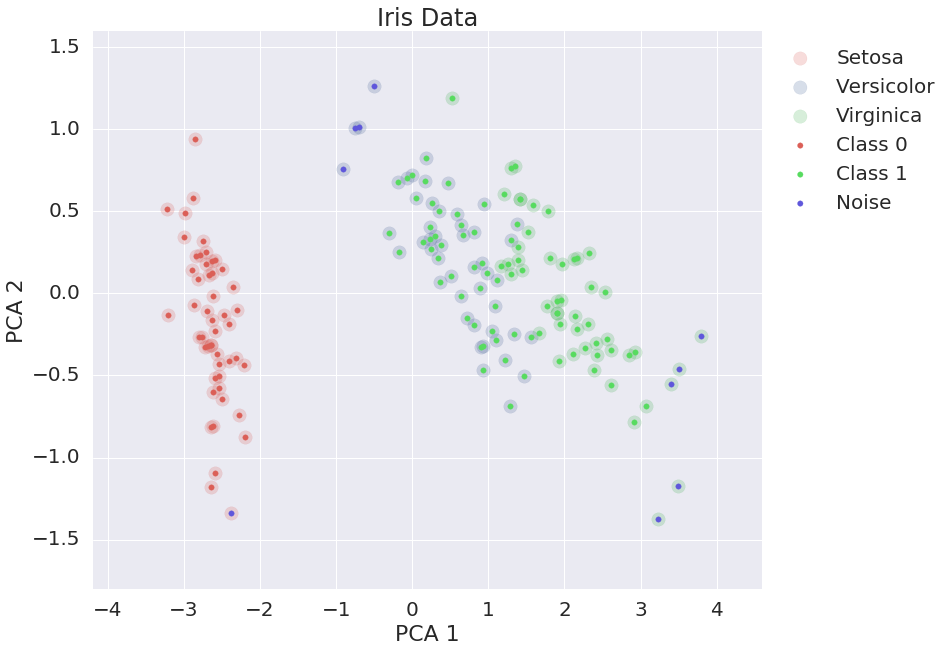

In [6]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
db = DBSCAN(eps=0.5, metric='euclidean', min_samples=10)
db.fit(x)

# Get cluster labels and assign plotting colors/labels.
dblbls = set(db.labels_)
dbclrs = sns.hls_palette(len(dblbls))
dbcls = ['Class {0}'.format(idx) if idx >= 0 else 'Noise' for idx in dblbls]

pc = pd.DataFrame(np.concatenate((x, db.labels_.reshape((150, 1))), axis=1), columns = cols)

# Make plot
sns.set(font_scale=2.0)
fig, ax = plt.subplots(figsize=(12, 10))

# Plot three known clusters
for idx in range(3):
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], color=clr[idx], label=lbls[idx], alpha=0.2, s=180)

# Plot DBSCAN clusters (and noise)
for idx in list(dblbls):
    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], color=dbclrs[idx], label=dbcls[idx], alpha=1, s=30)

ax.set_xlim(-4.2, 4.6)
ax.set_ylim(-1.8, 1.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(1, 1), loc=2)

sns.despine(offset=5, trim=True)
sns.set(font_scale=1.0)

-----

## Student Activity

In the preceding cells, we used a k-means and a DBSCAN algorithm to
cluster the Iris data. Now that you have run the Notebook,go back and
make the following changes to see how the results change.

1. Change the number of clusters in the k-means algorithm and visualize
the new clusters.
2. Change the `eps` parameter in the DBSCAN algorithm and visualize the
new clusters.
3. Change the `min_samples` parameter in the DBSCAN algorithm and
visualize the new clusters.
4. Try a different clustering algorithm on these data from the scikit
learn library, such as [Mean Shift][skms] or [Agglomerative
Clustering][skac].

Finally can you explain (feel free to use the class forums) why the
different algorithms performed differently when the parameters changed?

-----

[skms]: http://scikit-learn.org/stable/modules/clustering.html#mean-shift
[skac]: http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

## Handwritten Digits

Now we switch to a second type of data and explore clustering with the
handwritten digit data set. First we will load the data and review some
of the sample. After which, we will apply PCA to the data and use this
transformed data to compute clusters via the k-means and DBSCAN cluster
algorithms.

-----

Total number of samples = 1797


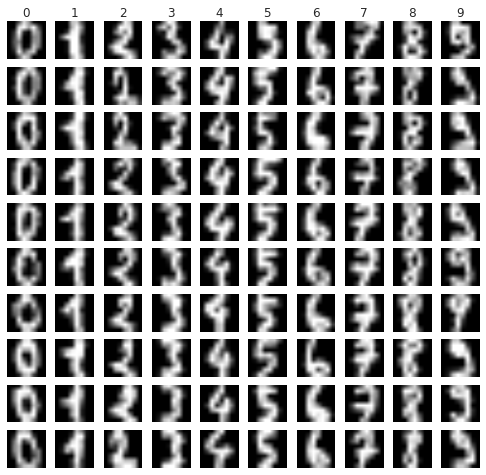

In [7]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

-----

### Clustering of image data

Now that these data are loaded, we first compute a PCA transformation of
the digit data before clustering to both speed up the computation and to
make the results more robust (by minimizing dimensions with little
signal). After clustering the data, we display the confusion matrix for
this data set (since we *know* the correct labels) before displaying a
_typical_ image for each cluster. These visualizations can be used to
better decode the confusion matrix, since the cluster ids will not match
the true cluster ids (which are simply the integer labels). After this,
we determine the best cluster for our _fake_ digit data, before moving
on to the DBSCAN algorithm.

-----

In [8]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Compute PCA for digit data and transform
pca = PCA(n_components=25, copy=True)
data = pca.fit_transform(x)

# We build our model assuming ten clusters
k_means = KMeans(n_clusters=10, n_init=10)

# We fit and transform our data to assign classes
ft_data = k_means.fit_transform(data)

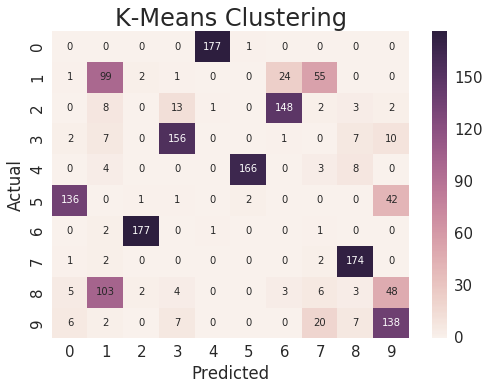

In [9]:
from helper_code import mlplots as mlp

l_test = y
l_pred = k_means.predict(data)

mlp.confusion(l_test, l_pred, range(10), 10, 'K-Means Clustering')

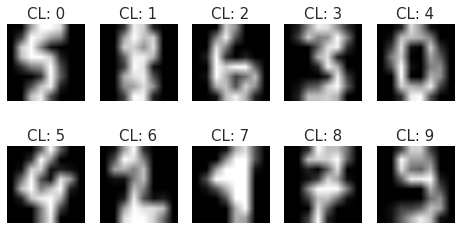

In [10]:
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(8,4))
plt.gray()

nrows = 2 ; ncols = 5

# We want to get the cluster closest to each cluster centroid
for idx, img in enumerate(np.argmin(ft_data,axis=0)):

    ax = plt.subplot(nrows, ncols, idx + 1)
    cl = k_means.labels_[img]

    # We want square images
    ax.set_aspect('equal')
        
    # Now show the images, by default pixels are shown as white on black.
    # To show black on white, reverse colormap: cmap=plt.cm.gray_r
    # To smooth pixelated images: interpolation='nearest'

    ax.imshow(images[img])
    
    # No tick marks for small plots
    ax.set_xticks([]) ; ax.set_yticks([])
    
    ax.set_title('CL: {0}'.format(cl))

plt.show()  

Actual : Predicted
  1    :     0
  1    :     4
  1    :     1
  1    :     7
  1    :     7
  1    :     9


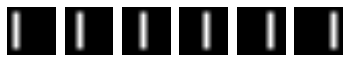

In [11]:
# Test on our ones
ones = hd.make_ones()
hd.plot_numbers(ones)

print('Actual : Predicted')

for one in ones:
    print('  1    :     {0}'.format(k_means.predict(pca.transform(one))[0])) 

Actual : Predicted
  7    :     6
  7    :     9
  7    :     4


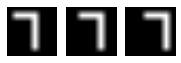

In [12]:
# Now test on our sevens
sevens = hd.make_sevens()
hd.plot_numbers(sevens)

print('Actual : Predicted')
for seven in sevens:
    print('  7    :     {0}'.format(k_means.predict(pca.transform(seven))[0])) 

-----

## Student Activity

In the preceding cells, we used the k-means algorithm to assign digit
images to clusters.  Now that you have run the Notebook, go back and
make the following changes to see how the results change.

1. Can you explain, in the class forums, the confusion matrix in terms
of the images associated with each cluster (remember that the results
can change each time the algorithm is run)?
2. Change the number of PCA components, both lower and higher, and
visualize the resulting changes. What are the predicted clusters for the
fake digit data
3. Change the number of clusters in the k-means clustering algorithm, how
do the results change?

-----

-----

### Algorithm Visually Explored

We can learn more about what the k-means algorithm is doing, by visually
exploring the clustering of the digit data in a **two**-dimensional
perspective. To accomplish this, we first project the digit data to two
dimensions, cluster the transformed data and then use this information
to assign clusters to a grid of points spanning these two dimensions. We
also overplot the centroid of each cluster.

-----

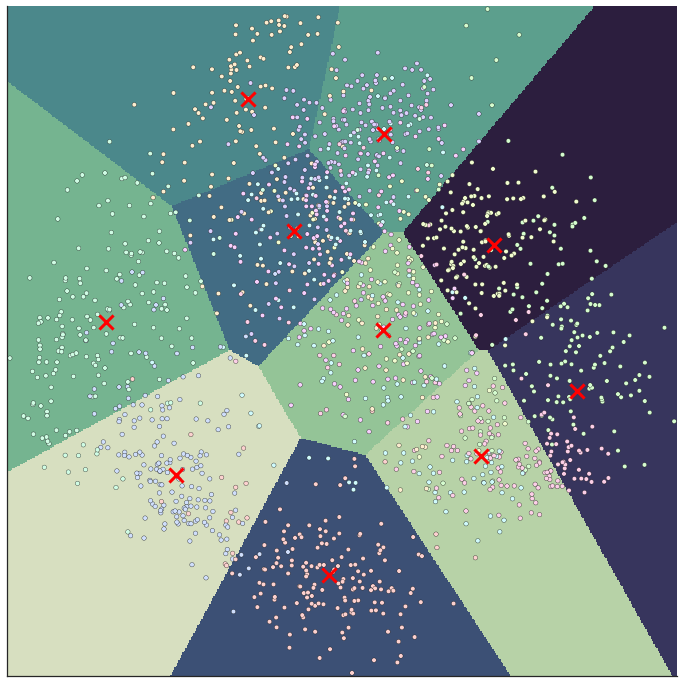

In [13]:
from matplotlib.colors import ListedColormap

cmp_bkg = ListedColormap(sns.cubehelix_palette(10, start=.5, rot=-.75))
cmp_pts = ListedColormap(sns.hls_palette(10, l=.9, s=.9))

# Compute PCA for digit data
pca = PCA(n_components=2, copy=True)
data = pca.fit_transform(x)

# We build our model assuming ten clusters
k_means = KMeans(n_clusters=10)

# We fit our data to assign classes
k_means.fit(data)

# Step size of the mesh. 
grid_size = 500

x_min, x_max = data[:, 0].min() - .25, data[:, 0].max() + .25
y_min, y_max = data[:, 1].min() - .25, data[:, 1].max() + .25

# Meshgrid gives two 2D arrays of the ppoints
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                     np.linspace(y_min, y_max, grid_size))

zz = k_means.predict(np.c_[xx.ravel(), yy.ravel()])

sns.set(style="ticks", font_scale=2.0)
fig, ax = plt.subplots(figsize=(12,12))

plt.pcolormesh(xx, yy, zz.reshape((grid_size, grid_size)), cmap=cmp_bkg)
    
# Draw the points
plt.scatter(data[:, 0], data[:, 1], c = y, s=20, cmap=cmp_pts)

# Plot the centroids as a red X
ctrs = k_means.cluster_centers_
plt.scatter(ctrs[:, 0], ctrs[:, 1], marker='x', s=200, linewidths=3, color='r')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])

sns.despine(left=False, bottom=False)

plt.show()

-----

## DBSCAN Clustering digits

While the K-Means algorithm produced interesting results, applying the
DBSCAN algorithm provides insight into the general application of a
clustering algorithm. In this case, we will simply use the DBSCAN
algorithm to identify clusters in our PCA transformed data. In the
following cells, we apply the clustering algorithm and visualize the
results. In this case, we simply display a randomly selected image from
each cluster. We could compute a more accurate statistical representation
(since we have known labels) or even an average image to better
understand what the algorithm is doing with these data.

----

In [14]:
dbsc = DBSCAN(eps=4, min_samples=50)
dbsc.fit(data)

from collections import Counter 
cnt =  Counter(dbsc.labels_)

# Display some basic results of the clustering
print('DBSCAN Cluster membership.')
print(25*'-')
for itm in cnt:
    if itm < 0:
        print('\nNoise Cluster: {1} members'.format(itm, cnt[itm]))
    else:
        print('Cluster {0}: {1} members'.format(itm, cnt[itm]))

DBSCAN Cluster membership.
-------------------------
Cluster 0: 136 members
Cluster 1: 1032 members
Cluster 2: 65 members
Cluster 3: 164 members

Noise Cluster: 400 members


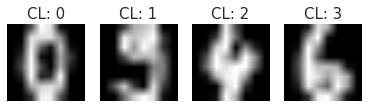

In [15]:
# We randomly select an image from each cluster, different results with each iteration
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(8,4))
plt.gray()

# Plot the images, we expect ten or fewer so keep old setup.
nrows = 2 ; ncols = 5

# We want to iterate through actual clusters and show representative image.
for idx, cl in enumerate(np.unique(dbsc.labels_)):

    if cl < 0:
        pass ; # Noise cluster
    
    else:
        
        # Data clusters, grab one image from each cluster
        cl_imgs = np.where(dbsc.labels_ == cl)
        img = np.random.choice(cl_imgs[0])
        
        # Now plot that image and label appropriately.
        ax = plt.subplot(nrows, ncols, idx + 1)
        cl = dbsc.labels_[img]

        # We want square images
        ax.set_aspect('equal')
        
        # Now show the images, by default pixels are shown as white on black.
        # To show black on white, reverse colormap: cmap=plt.cm.gray_r
        # To smooth pixelated images: interpolation='nearest'

        ax.imshow(images[img])
    
        # No tick marks for small plots
        ax.set_xticks([]) ; ax.set_yticks([])
    
        ax.set_title('CL: {0}'.format(cl))

plt.show()
sns.set(font_scale=1.0)

-----

## Student Activity

In the preceding cell, we used a DBSCAN algorithm to cluster the digit
data set. Now that you have run the Notebook, go back and run it again
(and again), how do the results change? 

Now, make the following changes to see how the cluster assignments
change.

1. Change the `eps` parameter, and see how many clusters are created and
how many images are assigned to each cluster.

2. Change the `min_samples` parameter, and see how many clusters are
created and how many images are assigned to each cluster.

3. Change the number of PCA components that are retained for clustering;
how does this affect the results?

Finally, consider how the number of images assigned to the _noise_
cluster (or are outliers) varies. Can you explain how the parameters
impact this quantity (feel free to use the class forums)?

-----
[etc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier